*Read section 8.1.2 of the book before using these notes.*

*Note that in this course, lecture notes are not sufficient, you must read the book for better understanding. Lecture notes are just implementing the concepts of the book on a dataset, but not explaining the concepts elaborately.*

Import libraries

In [3]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image

from sklearn.model_selection import train_test_split, cross_val_score
from six import StringIO
from sklearn.tree import export_graphviz, DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score

%matplotlib inline

In [6]:
# load the dataset
heart_df  = pd.read_csv('datasets/heart_disease_classification.csv')
print(heart_df .shape)
heart_df .head()

(303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
# print out target distribution
heart_df.target.value_counts()

target
1    165
0    138
Name: count, dtype: int64

In [8]:
# split the x and y data
X = heart_df.drop(columns=['target'])
y = heart_df.target

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Building a Classification Tree

We will build a classification tree to predict whether a person has heart disease, using the default parameters of the decision tree classifier.


In [11]:
# create a decision tree classifier
tree = DecisionTreeClassifier(random_state=42)

# fit the model to the training data
tree.fit(X_train, y_train)

# make predictions on the test data
y_pred = tree.predict(X_test)

# calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.2f}')

# train accuracy
y_train_pred = tree.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Train Accuracy: {train_accuracy:.2f}')

Test Accuracy: 0.75
Train Accuracy: 1.00


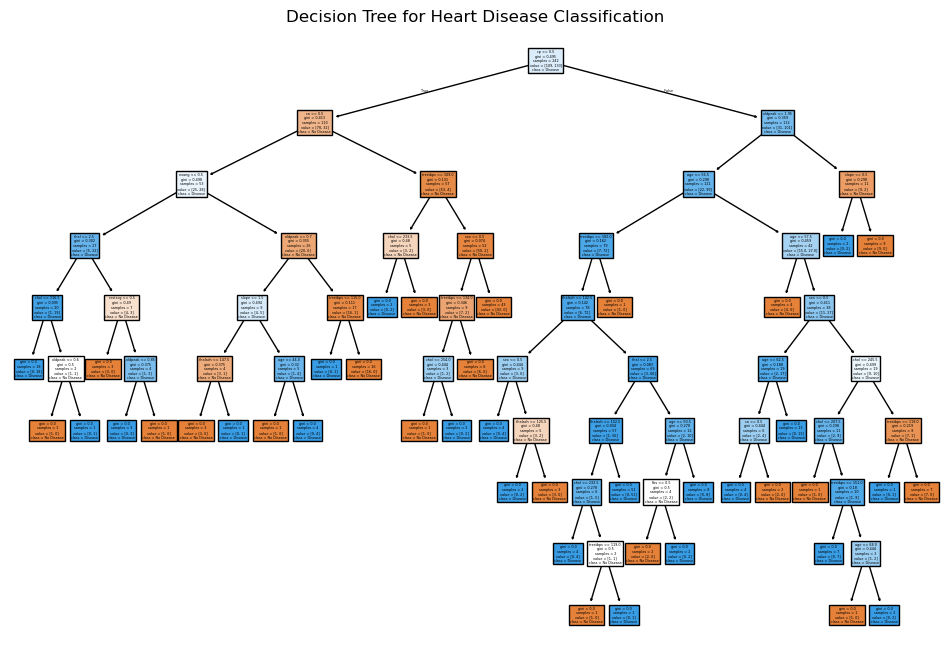

In [12]:
# plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(tree, filled=True, feature_names=X.columns, class_names=['No Disease', 'Disease'])
plt.title('Decision Tree for Heart Disease Classification');


In [54]:
# get the number of leaves in the tree
num_leaves = tree.get_n_leaves()
print(f'Number of leaves: {num_leaves}')

# get the depth of the tree
tree_depth = tree.get_depth()
print(f'Depth of the tree: {tree_depth}')


Number of leaves: 41
Depth of the tree: 9


Clearly, the model is overfitting, as indicated by a training accuracy of 100% and a much lower test accuracy of 75%.  
Next, we will explore different strategies to address and reduce overfitting.

## Pre-pruning: Hyperparameters Tuning

<b><u>Maximum depth of tree (`max_depth`)</u></b>
- Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.

<b><u>Minimum samples for a node split (`min_samples_split`)</u></b>
- Defines the minimum number of samples (or observations) which are required in a node to be considered for splitting.
- Used to control over-fitting. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.

<b><u>Minimum samples for a terminal node (`min_samples_leaf`)</u></b>
- Defines the minimum samples (or observations) required in a terminal node or leaf.
- Used to control over-fitting similar to `min_samples_split`.
- Generally lower values should be chosen for imbalanced class problems because the regions in which the minority class will be in majority will be very small.

<b><u>Maximum number of terminal nodes (`max_leaf_nodes`)</u></b>
- The maximum number of terminal nodes or leaves in a tree.

In [37]:
# hyperparameter tuning

from sklearn.model_selection import GridSearchCV

# define the parameter grid
param_grid = {
    'max_depth': list(range(1, 9)) + [None], 
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4]
}

# create a grid search object
grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
# fit the grid search to the training data
grid_search.fit(X_train, y_train)
# print the best parameters
print("Best parameters found: ", grid_search.best_params_)

# print the best score
print("Best score: ", grid_search.best_score_)
# get the best estimator
best_tree = grid_search.best_estimator_

# make predictions on the test data with the best estimator
y_pred_best = best_tree.predict(X_test)
# calculate the accuracy of the best estimator
best_accuracy = accuracy_score(y_test, y_pred_best)
print(f'Best Test Accuracy: {best_accuracy:.2f}')

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Best parameters found:  {'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best score:  0.7687074829931972
Best Test Accuracy: 0.85


In [38]:
# print out the best tree depth and number of leaves
best_num_leaves = best_tree.get_n_leaves()
print(f'Best Number of leaves: {best_num_leaves}')

best_tree_depth = best_tree.get_depth()
print(f'Best Depth of the tree: {best_tree_depth}')

Best Number of leaves: 21
Best Depth of the tree: 6


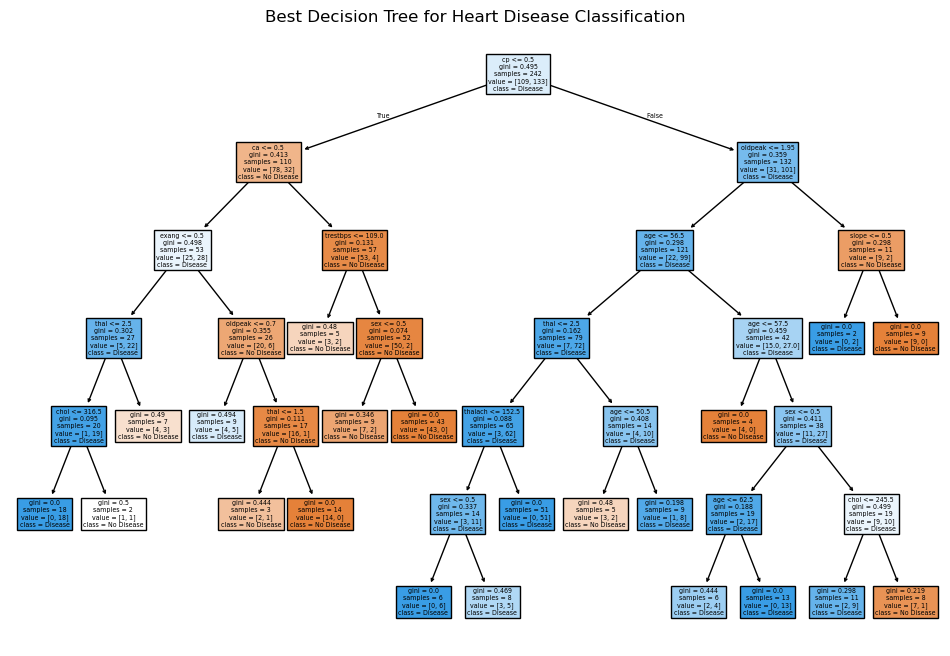

In [39]:
# plot the best decision tree
plt.figure(figsize=(12, 8))
plot_tree(best_tree, filled=True, feature_names=X.columns, class_names=['No Disease', 'Disease'])
plt.title('Best Decision Tree for Heart Disease Classification')
plt.show()

### Gini or entropy

In [ ]:
# define the parameter grid
param_grid_metric = {
    'max_depth': list(range(1, 9)) + [None], 
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4],
    # adding the criterion parameter to the grid search
    'criterion': ['gini', 'entropy']
}

# create a grid search object
grid_search_metric = GridSearchCV(estimator=tree, param_grid=param_grid_metric, cv=5, n_jobs=-1, verbose=2)
# fit the grid search to the training data
grid_search_metric.fit(X_train, y_train)
# print the best parameters
print("Best parameters found: ", grid_search_metric.best_params_)

# print the best score
print("Best score: ", grid_search_metric.best_score_)
# get the best estimator
best_tree = grid_search_metric.best_estimator_

# make predictions on the test data with the best estimator
y_pred_best = best_tree.predict(X_test)
# calculate the accuracy of the best estimator
best_accuracy = accuracy_score(y_test, y_pred_best)
print(f'Best Test Accuracy: {best_accuracy:.2f}')

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Best parameters found:  {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 20}
Best score:  0.7811224489795918
Best Test Accuracy: 0.85


In [43]:
# print out the best tree depth and number of leaves
best_num_leaves = best_tree.get_n_leaves()
print(f'Best Number of leaves: {best_num_leaves}')

best_tree_depth = best_tree.get_depth()
print(f'Best Depth of the tree: {best_tree_depth}')


Best Number of leaves: 11
Best Depth of the tree: 4


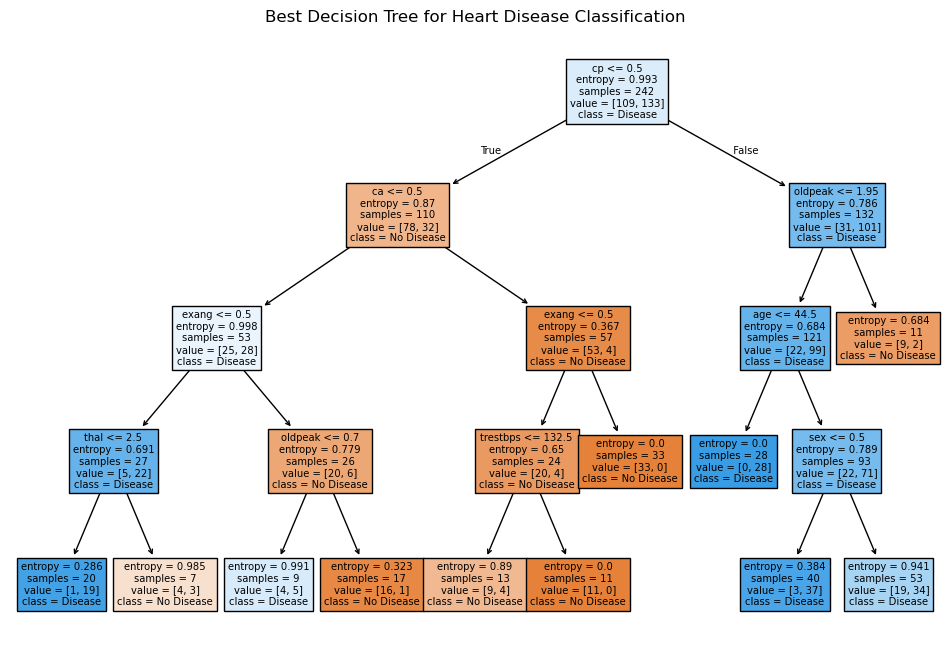

In [44]:
# plot the best decision tree
plt.figure(figsize=(12, 8))
plot_tree(best_tree, filled=True, feature_names=X.columns, class_names=['No Disease', 'Disease'])
plt.title('Best Decision Tree for Heart Disease Classification')
plt.show()

Both criteria aim to minimize impurity in splits, in pratice, they often lead to comparable performance in decision trees, even though their mathematical forulations differ

* **Gini**: Faster to compute (no logarithms) and often used for large datasets. so it is a good default. May produce slightly more complex trees.
* **Entropy**: Slower but aligns with information theory. Prefers splits that balance node sizes, leading to more interpretable trees.


## Post-pruning: Cost complexity pruning

Post-pruning, on the other hand, allows the decision tree to grow to its full extent and then prunes it back to reduce complexity. This approach first builds a complete tree and then removes or collapses branches that don’t significantly contribute to the model’s performance. One common post-pruning technique is called Cost-Complexity Pruning.

### step 1: calculate the cost complexity pruning path

In [ ]:
path = tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities


### step 2: Create trees with different ccp_alpha values and evaluate their performance

In [ ]:

# We'll skip the last alpha which would produce a single-node tree
alphas = ccp_alphas[:-1]

# Create empty lists to store the results
train_scores = []
test_scores = []
cv_scores = []
node_counts = []

# For each alpha value, fit a tree and evaluate
for alpha in alphas:
    # Create and train the model
    clf = DecisionTreeClassifier(ccp_alpha=alpha, random_state=42)
    clf.fit(X_train, y_train)
    
    # Record scores
    train_scores.append(accuracy_score(y_train, clf.predict(X_train)))
    test_scores.append(accuracy_score(y_test, clf.predict(X_test)))
    
    # Cross-validation score for robustness
    cv_score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    cv_scores.append(cv_score)
    
    # Record tree complexity
    node_counts.append(clf.tree_.node_count)


### Step 3: Visualize the results

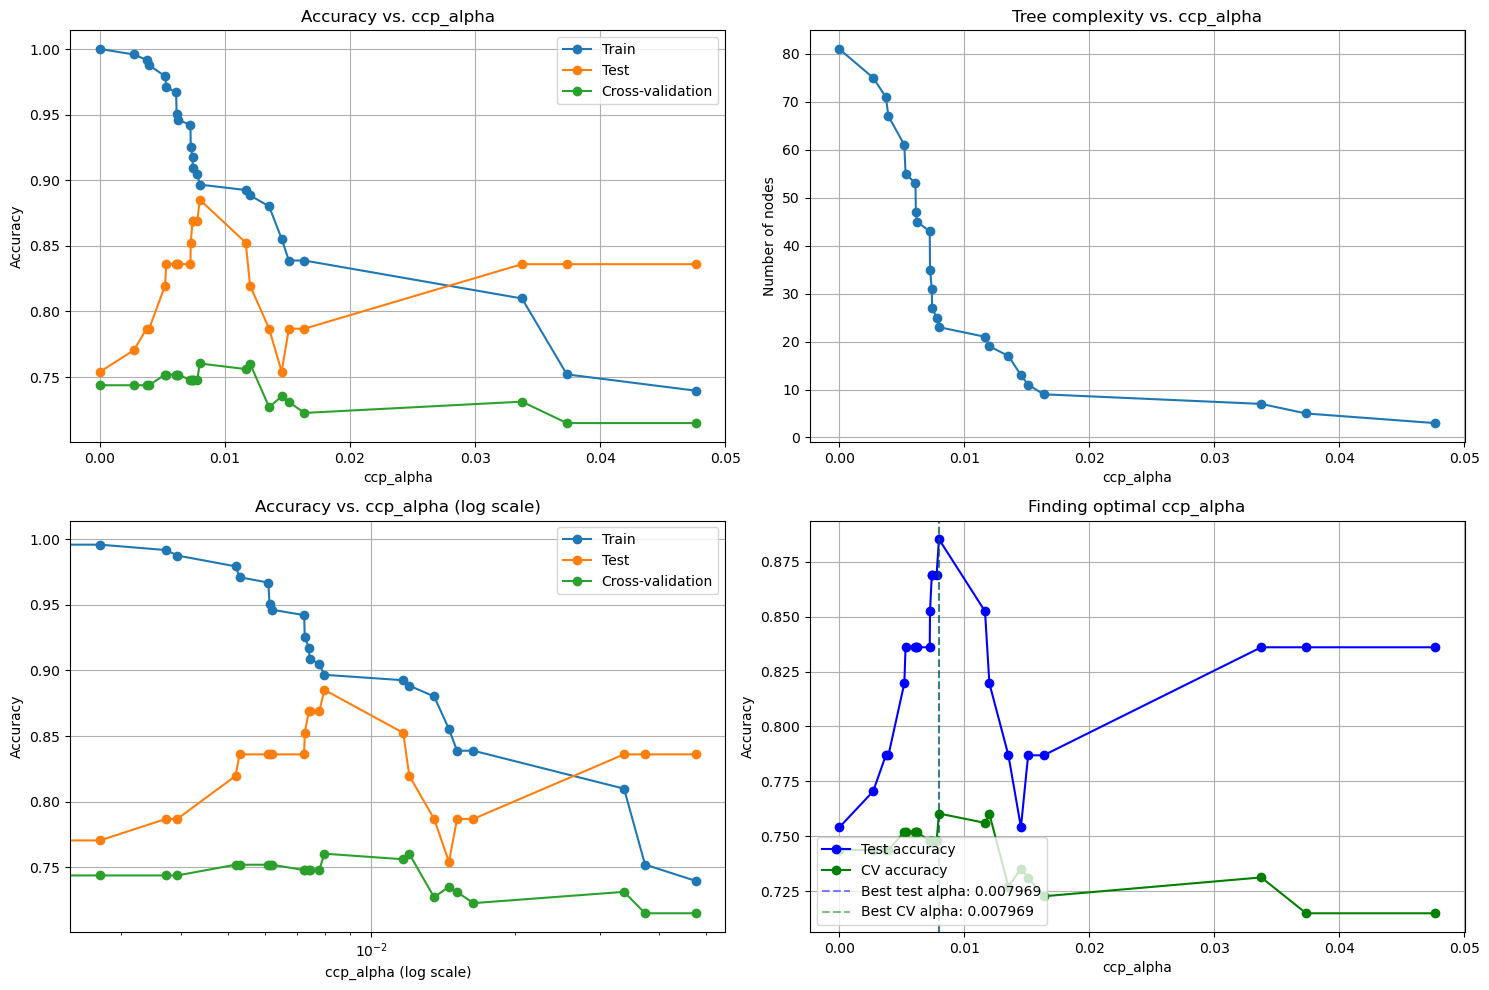

In [ ]:
# Step 3: Visualize the results
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Plot accuracy vs alpha
ax[0, 0].plot(alphas, train_scores, marker='o', label='Train')
ax[0, 0].plot(alphas, test_scores, marker='o', label='Test')
ax[0, 0].plot(alphas, cv_scores, marker='o', label='Cross-validation')
ax[0, 0].set_xlabel('ccp_alpha')
ax[0, 0].set_ylabel('Accuracy')
ax[0, 0].set_title('Accuracy vs. ccp_alpha')
ax[0, 0].legend()
ax[0, 0].grid(True)

# Plot number of nodes vs alpha
ax[0, 1].plot(alphas, node_counts, marker='o')
ax[0, 1].set_xlabel('ccp_alpha')
ax[0, 1].set_ylabel('Number of nodes')
ax[0, 1].set_title('Tree complexity vs. ccp_alpha')
ax[0, 1].grid(True)

# Log scale for better visualization of small alpha values
ax[1, 0].plot(alphas, train_scores, marker='o', label='Train')
ax[1, 0].plot(alphas, test_scores, marker='o', label='Test')
ax[1, 0].plot(alphas, cv_scores, marker='o', label='Cross-validation')
ax[1, 0].set_xlabel('ccp_alpha (log scale)')
ax[1, 0].set_ylabel('Accuracy')
ax[1, 0].set_title('Accuracy vs. ccp_alpha (log scale)')
ax[1, 0].set_xscale('log')
ax[1, 0].legend()
ax[1, 0].grid(True)

# Find best alpha based on test score
best_test_idx = np.argmax(test_scores)
best_test_alpha = alphas[best_test_idx]
best_test_acc = test_scores[best_test_idx]

# Find best alpha based on CV score (more robust)
best_cv_idx = np.argmax(cv_scores)
best_cv_alpha = alphas[best_cv_idx]
best_cv_acc = cv_scores[best_cv_idx]

# Plot highlighting best points
ax[1, 1].plot(alphas, test_scores, 'b-', marker='o', label='Test accuracy')
ax[1, 1].plot(alphas, cv_scores, 'g-', marker='o', label='CV accuracy')
ax[1, 1].axvline(x=best_test_alpha, color='blue', linestyle='--', alpha=0.5, 
                label=f'Best test alpha: {best_test_alpha:.6f}')
ax[1, 1].axvline(x=best_cv_alpha, color='green', linestyle='--', alpha=0.5,
                label=f'Best CV alpha: {best_cv_alpha:.6f}')
ax[1, 1].set_xlabel('ccp_alpha')
ax[1, 1].set_ylabel('Accuracy')
ax[1, 1].set_title('Finding optimal ccp_alpha')
ax[1, 1].legend(loc='lower left')
ax[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Print the optimal alpha values and corresponding metrics
print(f"Best alpha based on test score: {best_test_alpha:.6f} (Accuracy: {best_test_acc:.4f}, Nodes: {node_counts[best_test_idx]})")
print(f"Best alpha based on CV score: {best_cv_alpha:.6f} (Accuracy: {best_cv_acc:.4f}, Nodes: {node_counts[best_cv_idx]})")


### Step 4: Create the final model with the optimal alpha

In [ ]:
# Using CV-based alpha as it's more robust against overfitting
final_model = DecisionTreeClassifier(ccp_alpha=best_cv_alpha, random_state=42)
final_model.fit(X_train, y_train)

# Evaluate the final model
train_acc = accuracy_score(y_train, final_model.predict(X_train))
test_acc = accuracy_score(y_test, final_model.predict(X_test))

print(f"\nFinal model performance:")
print(f"Training accuracy: {train_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")
print(f"Tree nodes: {final_model.tree_.node_count}")
print(f"Tree depth: {final_model.get_depth()}")

Best alpha based on test score: 0.007969 (Accuracy: 0.8852, Nodes: 23)
Best alpha based on CV score: 0.007969 (Accuracy: 0.7604, Nodes: 23)

Final model performance:
Training accuracy: 0.8967
Test accuracy: 0.8852
Tree nodes: 23
Tree depth: 6


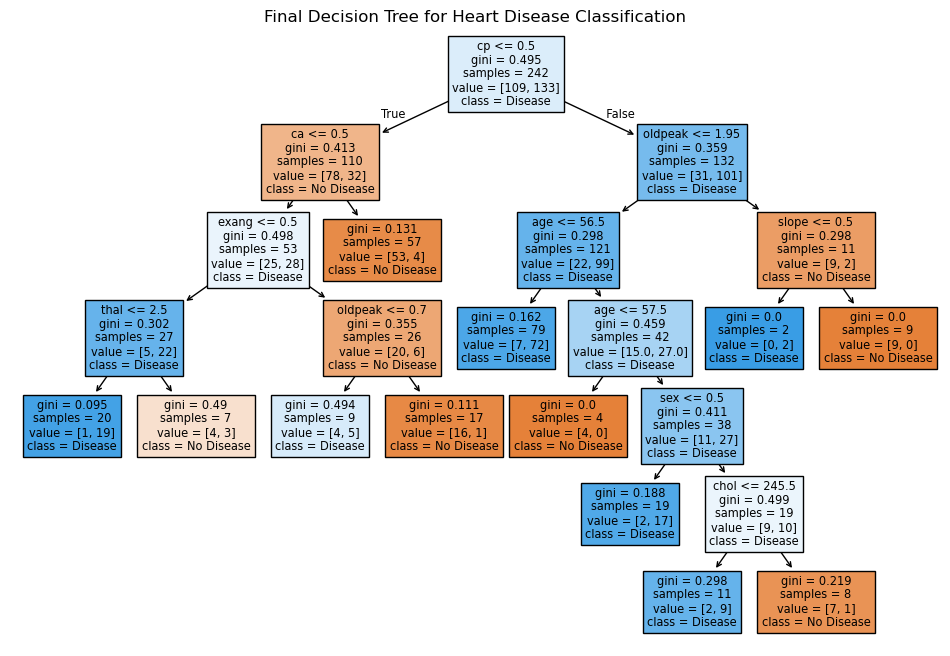

In [49]:
# plot the final decision tree
plt.figure(figsize=(12, 8))
plot_tree(final_model, filled=True, feature_names=X.columns, class_names=['No Disease', 'Disease'])
plt.title('Final Decision Tree for Heart Disease Classification')
plt.show()

Post-pruning can potentially create more optimal trees, as it considers the entire tree structure before making pruning decisions. However, it can be more computationally expensive.

Both approaches aim to find a balance between model complexity and performance, with the goal of creating a model that generalizes well to unseen data. The choice between pre-pruning and post-pruning (or a combination of both) often depends on the specific dataset, the problem at hand, and of course, computational resources available.

## Feature Importance in Decision Trees

Decision tree algorithms, such as Classification and Regression Trees (CART), compute **feature importance** scores based on how much each feature contributes to reducing the splitting criterion (e.g., **Gini impurity** or **entropy**).

This methodology extends naturally to **ensemble models** like **Random Forests** and **Gradient Boosting**, which average feature importance across all trees in the ensemble.

Once a model is trained, the relative importance of each feature can be accessed using the `.feature_importances_` attribute. These scores indicate how valuable each feature was in constructing the decision rules that led to the model’s predictions.

In [51]:
importances  = final_model.feature_importances_

# Create a DataFrame for easier visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the DataFrame
feature_importance_df

,Feature,Importance
2,cp,0.340102
11,ca,0.145273
9,oldpeak,0.139508
8,exang,0.113871
0,age,0.095885
4,chol,0.056089
10,slope,0.041242
12,thal,0.035531
1,sex,0.032499
3,trestbps,0.000000


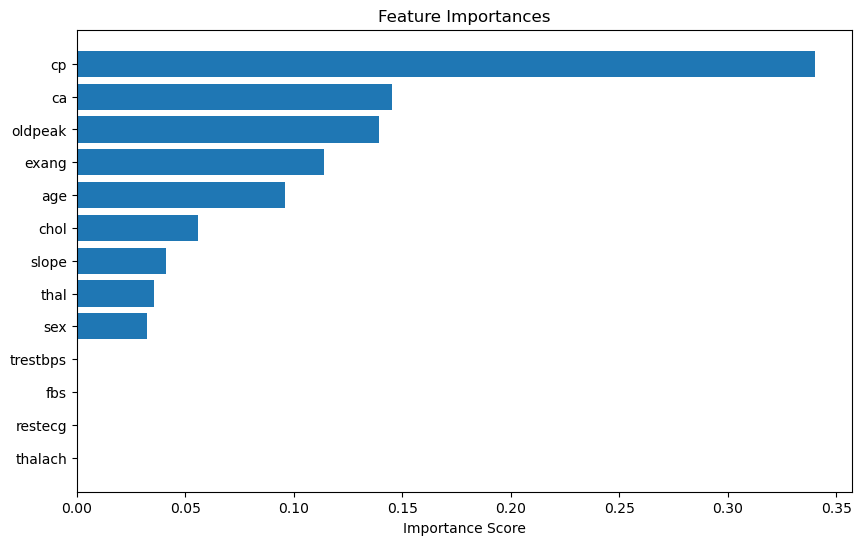

In [52]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Importance Score")
plt.title("Feature Importances")
plt.gca().invert_yaxis()  # Most important feature at the top
plt.show()

### Do We Need Feature Selection or Regularization with Tree Models?

When using **tree-based models** (e.g., Decision Trees, Random Forests, Gradient Boosting) and you have a **small number of predictors**, you typically **don’t need to worry much about feature selection or regularization**. Here’s why:

-  **Tree models inherently ignore uninformative features**. They only split on features that reduce impurity (e.g., Gini or entropy), so irrelevant features tend to receive **zero or very low importance**.
-  **Ensemble methods** like Random Forest or Boosting average over many trees. Features that don’t help prediction are rarely used across the ensemble.
-  **Including unimportant features won't significantly hurt model performance** in small feature spaces. The model will usually ignore them during training.
-  **However**, even in small feature sets, irrelevant features may slightly:
  - Increase model variance
  - Increase training time
  - Reduce interpretability

### Bottom Line
> If the number of predictors is small, you can typically skip feature selection and regularization when using tree-based models — they will handle irrelevant features gracefully.


## Next Lecture

A single decision tree is highly susceptible to **overfitting**, especially on noisy or complex datasets.

In this notebook, we explored two techniques to reduce variance and improve generalization:

- **Pre-pruning** (e.g., setting `max_depth`, `min_samples_split`, etc)
- **Post-pruning** (e.g., cost-complexity pruning)

In the next lecture, we’ll introduce another powerful method to combat overfitting:  
👉 **Bagging (Bootstrap Aggregating)** — an ensemble technique that builds multiple trees and averages their predictions to reduce variance and improve robustness.
